In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import pickle

In [31]:
import xgboost as xgb
xgb.__version__

'1.6.1'

In [32]:
pd.__version__

'1.4.2'

In [33]:
np.__version__

'1.22.4'

In [34]:
sklearn.__version__

'1.1.1'

In [38]:
#train_df=pd.read_csv("train_new.csv")
#test_df=pd.read_csv("test_new.csv")
data = pd.read_csv('feature_improved_V2.csv')

In [36]:

#data = pd.read_excel('feature_improved_V4.xlsx')

In [39]:
data.shape

(1992, 33)

### Data Cleaning

In [40]:
len(data.columns)

33

In [41]:
data['new_class_label'].unique()

array(['0', '3', '1', 'doubt(0)', 'doubt(1)', 'doubt', ' doubt(1)'],
      dtype=object)

In [42]:
data = data.drop(['mac_address', "cluster"], axis = 1)

In [43]:
# dropping certain values from new_class_label_column
data = data[data['new_class_label'].notna()]
values_to_drop = [3,'doubt', 'doubt(1)', ' doubt(1)', 'doubt(0)']
data = data[data.new_class_label.isin(values_to_drop) == False]
data.new_class_label.unique()

array(['0', '3', '1'], dtype=object)

In [44]:
data['new_class_label'] = data['new_class_label'].astype(float)
data['new_class_label'] = data['new_class_label'].astype(int)
data['new_class_label'].unique()

array([0, 3, 1])

In [45]:
values_to_drop = [3]
data = data[data.new_class_label.isin(values_to_drop) == False]

In [46]:
data.shape

(1677, 31)

In [47]:
data.columns

Index(['amps_f1', 'amps_f2', 'amps_f3', 'amps_f4', 'amps_f5', 'amps_f6',
       'zeroes_f1', 'zeroes_f2', 'zeroes_f3', 'zeroes_f4', 'zeroes_f5',
       'ones_f1', 'ones_f2', 'ones_f3', 'ones_f4', 'ones_f5', 'm1', 'm2', 'm3',
       'S', 'r_sm1', 'r_sm2', 'r_sm3', 'n1', 'n2', 'n3', 'T', 'r_tn1', 'r_tn2',
       'r_tn3', 'new_class_label'],
      dtype='object')

### Model Training

In [48]:
y=data['new_class_label']
x=data.drop(['new_class_label'],axis = 1)

In [49]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [50]:
#getting the class label counts
y_train.value_counts()

0    1189
1     152
Name: new_class_label, dtype: int64

In [51]:
#checking the skewness
print('Percentage of  having short cycles: {}%'.format(np.round((list(y_train).count(1)/len(y_train))*100)))
print('Percentage of  having normal cycles: {}%'.format(np.round(list(y_train).count(0)/len(y_train)*100)))

Percentage of  having short cycles: 11.0%
Percentage of  having normal cycles: 89.0%


## applying XGBoost

In [52]:
print('Shape of x_train is: {}'.format(x_train.shape))
print('Shape of x_test is: {}'.format(x_test.shape))
print('----------------------------------------------')
print('Shape of y_train is: {}'.format(y_train.shape))
print('Shape of y_test is: {}'.format(y_test.shape))

Shape of x_train is: (1341, 30)
Shape of x_test is: (336, 30)
----------------------------------------------
Shape of y_train is: (1341,)
Shape of y_test is: (336,)


In [53]:
parameters = {
    'eval_metric':['aucpr'],
    'use_label_encoder':[False],
    'n_estimators':[1,5,10,15,20,25,30,40,50,100], # number of decision trees used in Xgboost model
    'scale_pos_weight': [1,2,3,4,5,6,7,8,9,10], # used to tackle unbalanced datasets(same as upsampling, SMOTE,etc)
    'subsample':[0.75], # how much % of data you are taking for estimator building.
    'lambda':[100], #perform L2 regularization on leaf weights(tackle overfitting)(control how deep a tree can grow)
    'eta':[0.2], # Learning rate(new weight updation after every epoch in a conservative manner)
    'gamma':[0.25], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    'colsample_bytree':[0.8],
    'colsample_bylevel':[0.8],
    'colsample_bynode':[0.8]
}

In [54]:
#initializing xgboost model
x_cfl=XGBClassifier()
clf = GridSearchCV(estimator=x_cfl, param_grid=parameters, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True)
clf.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bylevel': [0.8], 'colsample_bynode': [0.8],
                         'colsample_bytree': [0.8], 'eta': [0.2],
                         'eval_metric': ['aucpr'], 'gamma': [0.25],
                         'lambda': [100],
                         'n_estimators': [1, 5, 10, 15, 20, 25, 30, 40, 50,
                                          100],
                         'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'subsample': [0.75], 'use_label_encoder': [False]},
             return_train_score=True, scoring='roc_auc')

In [55]:
#best parameters after training
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.2,
              eval_metric='aucpr', gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=100, learning_rate=0.200000003,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

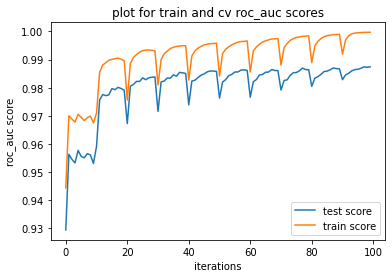

In [25]:
#here test score refers to the cv score
x_axis = [i for i in range(100)]
plt.plot(x_axis,clf.cv_results_['mean_test_score'])
plt.plot(x_axis,clf.cv_results_['mean_train_score'])
plt.legend(["test score", "train score"], loc ="lower right")
plt.xlabel('iterations')
plt.ylabel('roc_auc score')
plt.title('plot for train and cv roc_auc scores')
plt.show()

In [56]:
#calibrating the model to get the probabilities
calibration_clf = CalibratedClassifierCV(clf.best_estimator_)
calibration_clf.fit(x_train,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=0.8,
                                                    colsample_bynode=0.8,
                                                    colsample_bytree=0.8,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eta=0.2,
                                                    eval_metric='aucpr',
                                                    gamma=0.25, gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    lambda=100,
                                                    learning_rate=0.200000003,
                                                    max_bin=256,
                                                    max_cat_to_onehot=4,
                                                    max_delta_step=0,
                                                    max_depth=6, max_leaves=0,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints='()',
                                                    n_estimators=100, n_jobs=0,
                                                    num_parallel_tree=1,
                                                    predictor='auto',
                                                    random_state=0, ...))

In [57]:
predict_y_test = calibration_clf.predict(x_test)
predict_y_train = calibration_clf.predict(x_train)
predict_y_proba_test = calibration_clf.predict_proba(x_test)

In [ ]:
# we are saving the weights of the model using joblib
import joblib
model_file_name = "DEMO-local-xgboost-model"  
joblib.dump(calibration_clf, model_file_name) 

## Pickle file of model

In [ ]:
filename = "xgboost_model"
pickle.dump(calibration_clf,open(filename,'wb'))

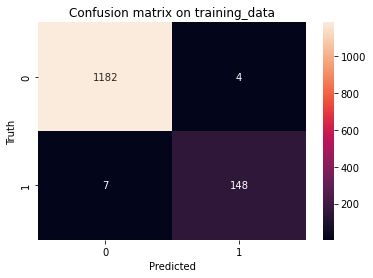

----------------------------
TP: 148
TN: 1182
FP: 4
FN: 7
F1-score: 0.964169381107492
accuracy: 0.9917971662938105


In [58]:
# this is the confusion matrix for training data 
cf_matrix=confusion_matrix(predict_y_train, y_train)
cf_matrix

sns.heatmap(confusion_matrix(predict_y_train,y_train), annot=True, fmt='d')
plt.title('Confusion matrix on training_data')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print("----------------------------")

tn, fp, fn, tp = confusion_matrix(predict_y_train, y_train).ravel()
print('TP: {}'.format(tp))
print('TN: {}'.format(tn))
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))


print('F1-score: {}'.format(f1_score(predict_y_train,y_train)))
print('accuracy: {}'.format((tp+tn)/(tp+tn+fp+fn)))

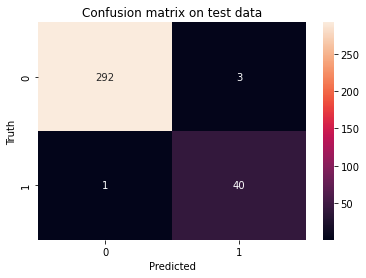

----------------------------
----------------------------
TP: 40
TN: 292
FP: 3
FN: 1
----------------------------
F1-score: 0.9523809523809524
accuracy: 0.9880952380952381


In [59]:
#performance metrics on test data
#print('Confusion matrix:')
#print(confusion_matrix(y_test,predict_y_test))
#plt.figure(figsize = (6.5,5))
sns.heatmap(confusion_matrix(y_test,predict_y_test), annot=True, fmt='d')
plt.title('Confusion matrix on test data')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print("----------------------------")

tn, fp, fn, tp = confusion_matrix(y_test,predict_y_test).ravel()
print("----------------------------")

print('TP: {}'.format(tp))
print('TN: {}'.format(tn))
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))
print("----------------------------")

print('F1-score: {}'.format(f1_score(y_test,predict_y_test)))
print('accuracy: {}'.format((tp+tn)/(tp+tn+fp+fn)))


### Predicted data for FN, FP, TP graphs

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
preprocessed_data = pd.read_csv('feature_improved_V2.csv')

In [ ]:
predicted_data=get_predicted_data(y_test,predict_y_test,predict_y_proba_test.T[1], preprocessed_data)
predicted_data.to_csv('predicted_data_xgboost_V_NEW.csv',index=False)

In [ ]:
predicted_data.head()

In [ ]:
#features Importance
features = x.columns
features
gain = clf.best_estimator_.feature_importances_
plt.figure(figsize = (10, 8))
plt.barh(features , gain)
plt.xlabel("Score")
plt.ylabel("features")
plt.legend(["Feature Importance"])
plt.show()

### Prediction on new week data

In [ ]:
test_data = pd.read_excel("doubt_data.xlsx")
test_data

In [ ]:
test_data['new_class_labels'].unique()

In [ ]:
test_data.columns

In [ ]:
test_data = test_data[test_data.new_class_labels != 'doubt']

In [ ]:
test_data['new_class_labels'] = test_data['new_class_labels'].astype(float)
test_data['new_class_labels'] = test_data['new_class_labels'].astype(int)
test_data['new_class_labels'].unique()

In [ ]:
values_to_drop = [3]
test_data = test_data[test_data.new_class_labels.isin(values_to_drop) == False]

In [ ]:
test_data.shape

In [ ]:
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
test_data=test_data.drop_duplicates()

In [ ]:
#test_y1=test_data['new_class_labels']
test_data1=test_data.drop(['mac_address'],axis = 1)

In [ ]:
test_data2=test_data1.drop(['cluster'],axis = 1)

In [ ]:
test_data3=test_data2.drop(['new_class_label'],axis = 1)

In [ ]:
test_data3.shape

In [ ]:
test_data4 = np.array(test_data3).reshape(85,30)

In [ ]:
import pickle
loaded_model = pickle.load(open(xgboost_model,'rb'))
#model_prediction=loaded_model.predict(test_x1)

In [ ]:
file = open("model_pickle",'rb')
object_file = pickle.load(file)

In [ ]:
object_file.predict(test_data4)

In [ ]:
sns.heatmap(confusion_matrix(test_y1,model_prediction), annot=True, fmt='d')
plt.title('Confusion matrix on weekdays testing data')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print("----------------------------")

tn, fp, fn, tp = confusion_matrix(test_y1,model_prediction).ravel()
print("----------------------------")

print('TP: {}'.format(tp))
print('TN: {}'.format(tn))
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))
print("----------------------------")

print('F1-score: {}'.format(f1_score(test_y1,model_prediction)))
print('accuracy: {}'.format((tp+tn)/(tp+tn+fp+fn)))

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
def get_predicted_data(class_label,y_pred,y_prob,preprocessed_data):
    class_label_index = class_label.index.tolist()
    mac_address = []
    for ind in class_label_index:
        mac_address.append(preprocessed_data.iloc[ind]['mac_address'])
                
    return pd.DataFrame({'mac_address':mac_address,'actual_class':class_label,
                         'predicted_class':y_pred,'confidence_score':y_prob})

In [ ]:
preprocessed_data = pd.read_csv("test_v2.csv")

In [ ]:
predicted_data=get_predicted_data(test_y1,model_prediction,predict_y_proba_test1.T[1], preprocessed_data)

In [ ]:
predicted_data

In [ ]:
predicted_data.to_csv('predicted_test_v2.csv',index=False)

In [ ]:
predicted_data.tail(60)

In [ ]:
with open('model_pickle','wb') as xgboost_model_pickle:
    pickle.dump(calibration_clf,xgboost_model_pickle)

In [ ]:
import xgboost as xgb

xgb.__version__

In [ ]:
import sklearn
sklearn.__version__